In [1]:
%load_ext autoreload
%autoreload 2

In [66]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from utils import data_load
from dateutil.parser import parse as parse_date
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import statsmodels.api as sm

import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi']= 300
mpl.rcParams['font.family'] = 'Serif'

In [20]:
sns.set()

In [61]:
SUCCESS_THRESHOLD = 7.5

In [21]:
ratings = data_load.load_imdb_title_ratings()
ratings.head()

,tconst,average_rating,num_votes
0,tt0000001,5.7,1922
1,tt0000002,5.8,259
2,tt0000003,6.5,1735
3,tt0000004,5.6,174
4,tt0000005,6.2,2548


In [40]:
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True

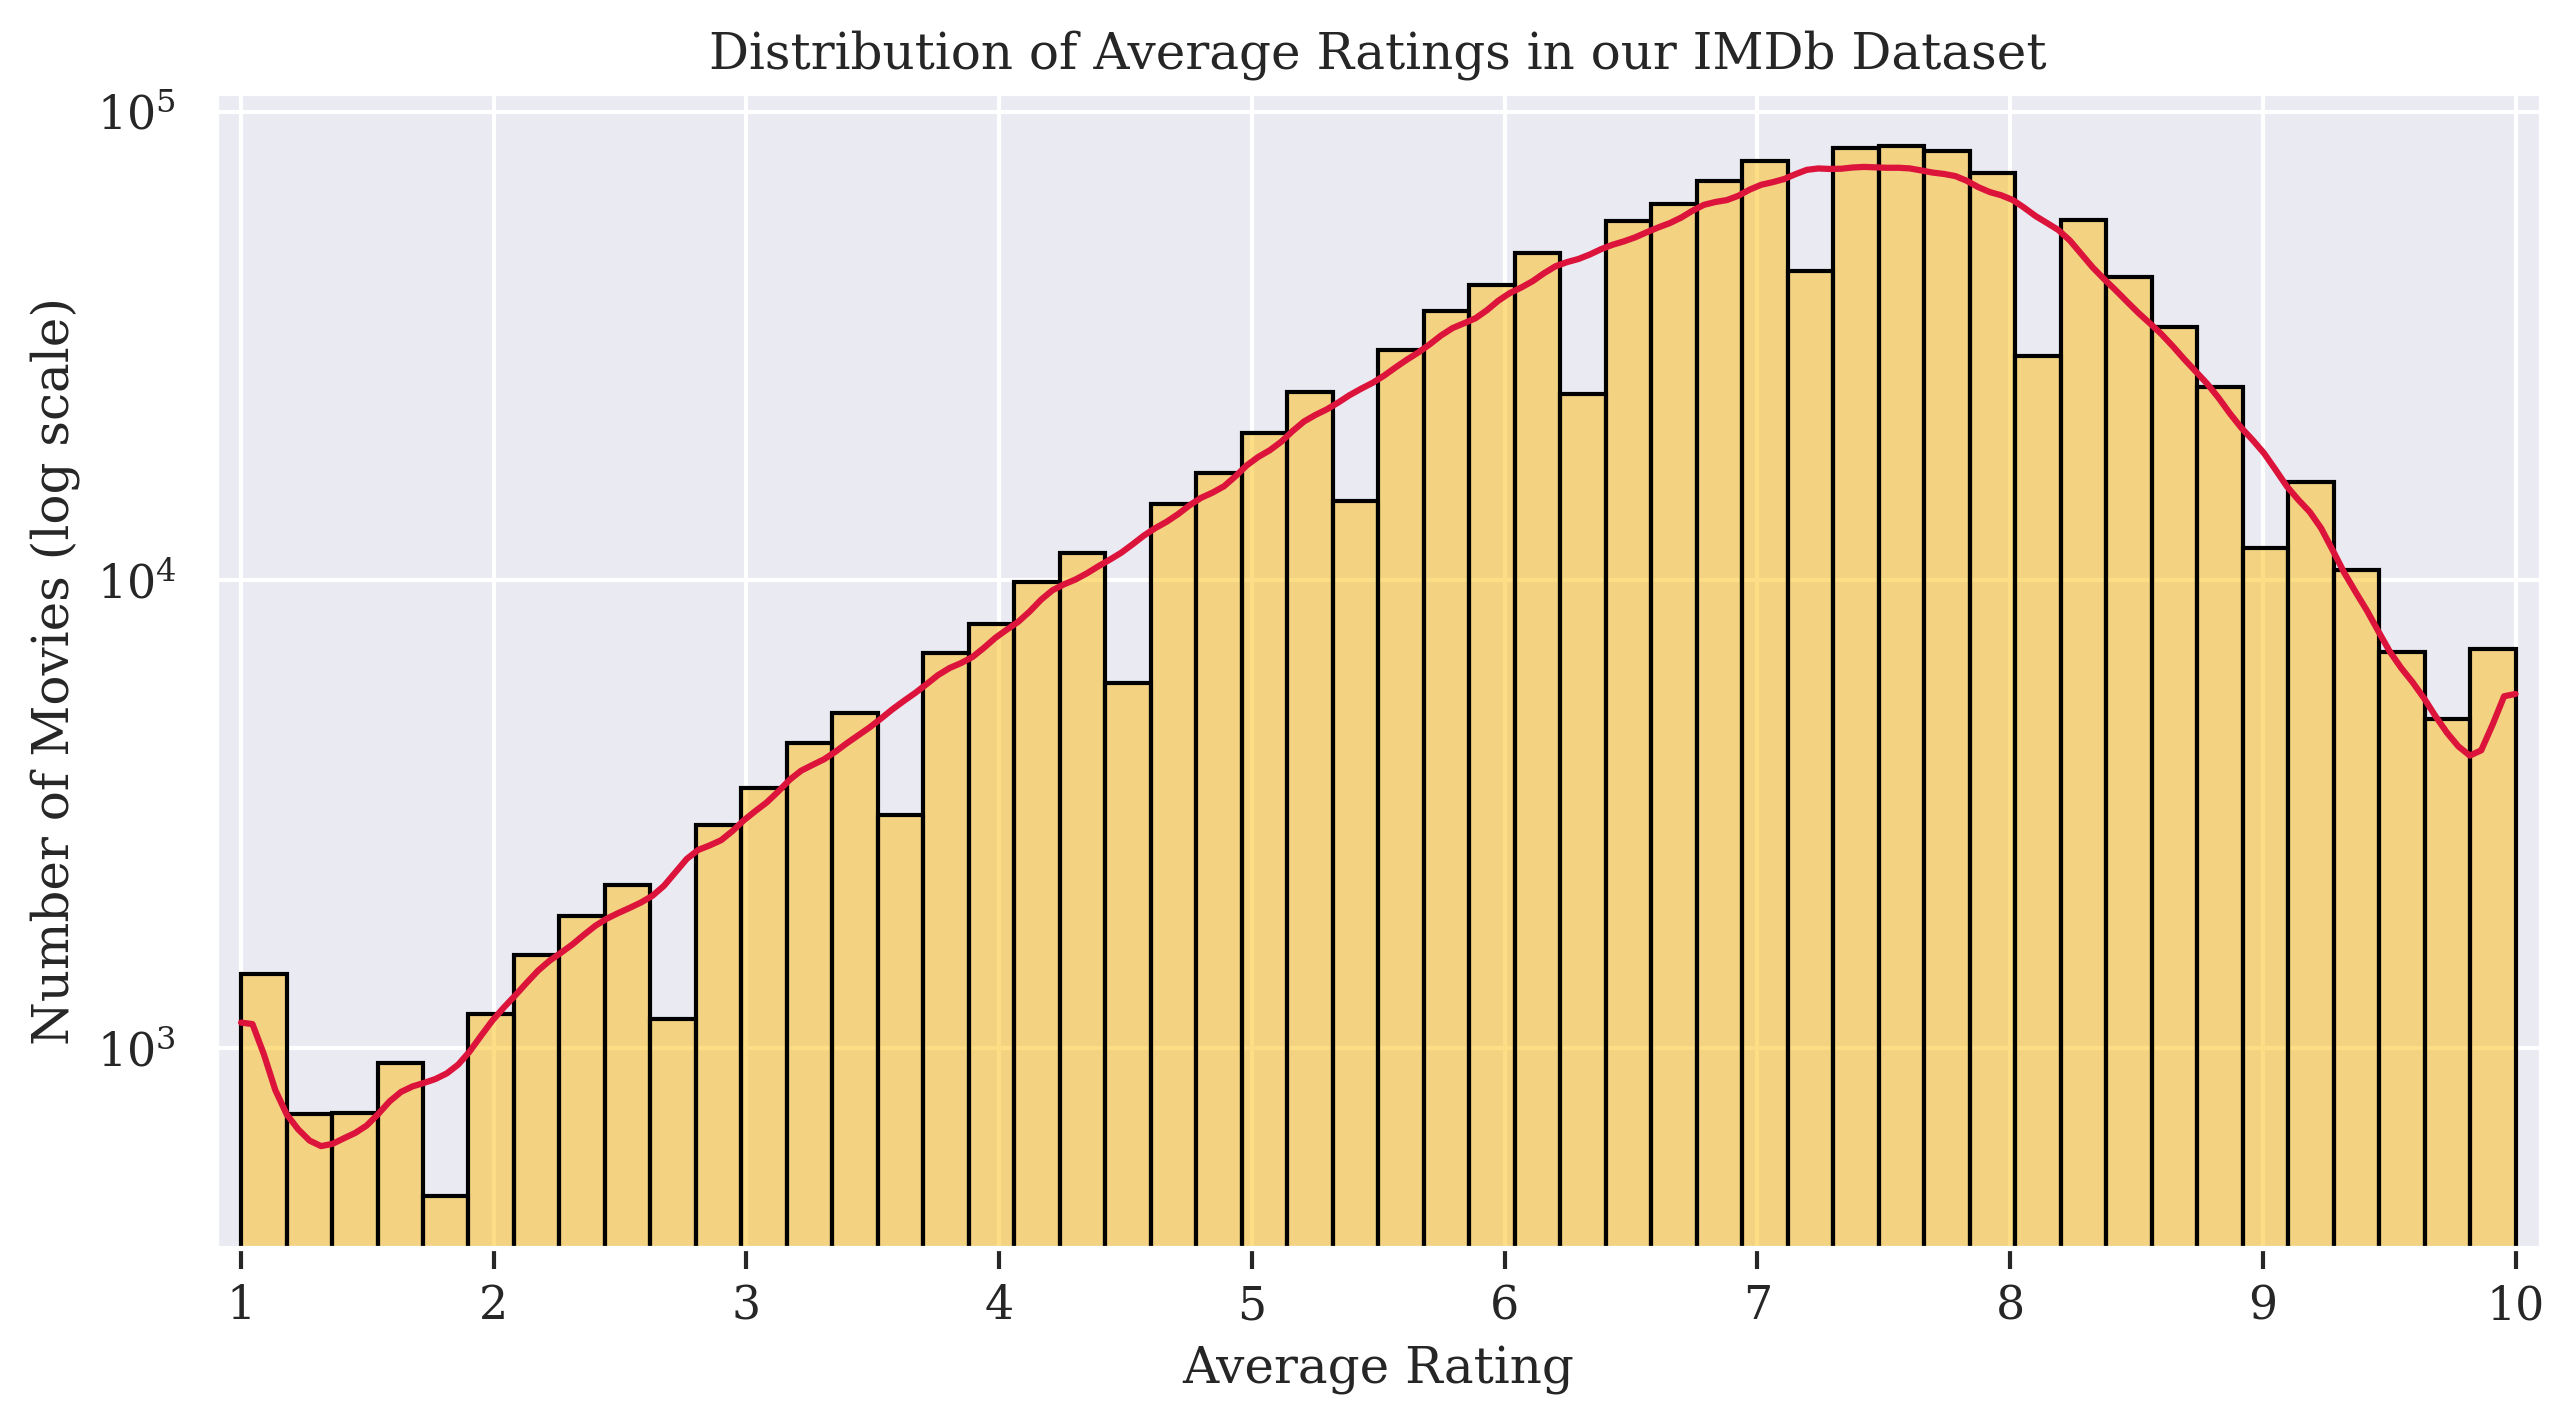

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ratings['average_rating'], bins=50, ax=ax, kde=True, color="#fcbe11")
ax.lines[0].set_color('#000')
ax.set_xlim(0.9, 10.1)
ax.set_xticks(np.arange(1, 11))
ax.set_yscale('log')
ax.set_xlabel('Average Rating')
ax.set_ylabel('Number of Movies (log scale)')
_ = ax.set_title('Distribution of Average Ratings in our IMDb Dataset')
for patch in ax.patches:
    patch.set_edgecolor("#000")
fig.savefig('../docs/static/plots/ratings_distribution.png', bbox_inches='tight', dpi=600)

In [59]:
director_df = pd.read_pickle("../data/post_processing/director_df.pkl")
is_directed_by_df = pd.read_pickle("../data/post_processing/is_directed_by_df.pkl")
movie_df = pd.read_pickle("../data/post_processing/movie_df.pkl")

In [63]:
movie_director = pd.merge(pd.merge(director_df, is_directed_by_df, on='director_id'), movie_df, on='movie_id')[['director_id', 'birth_year', 'death_year', 'release_date', 'average_rating']]
movie_director.dropna(inplace=True)

movie_director['release_year'] = movie_director['release_date'].dt.year
movie_director.drop(['release_date'], axis=1, inplace=True)

movie_director['director_age'] = (movie_director['release_year'] - movie_director['birth_year'])
movie_director = movie_director[movie_director['director_age'] > 18]
movie_director = movie_director[movie_director['director_age'] < 100]

# a movie is a success if rating higher than threshold and release before director's death
movie_director['success'] = np.where((movie_director.average_rating > SUCCESS_THRESHOLD) & (movie_director.release_year < movie_director.death_year),1,0)

movie_director.head()

,director_id,birth_year,death_year,average_rating,release_year,director_age,success
0,nm0000005,1918,2007,7.7,1955,37,1
1,nm0000005,1918,2007,7.2,1950,32,0
2,nm0000005,1918,2007,7.1,1960,42,0
3,nm0000005,1918,2007,7.6,1982,64,1
4,nm0000005,1918,2007,6.4,1948,30,0


In [64]:
directors = {}
for director, group in movie_director.groupby(['director_id', 'success']):        
    if director[1] == 1:
        directors[director[0]] = [1, group["director_age"].min()]
    else:
        if director[0] in directors:
            continue
        else:
            directors[director[0]] = [0, group["director_age"].max()]
director_km = pd.DataFrame(directors).transpose()
director_km.rename(columns={director_km.columns[0]: 'success', director_km.columns[1]: 'success_age'}, inplace=True)
director_km.head()

,success,success_age
nm0000005,1,37
nm0000008,0,37
nm0000009,0,42
nm0000018,0,59
nm0000019,1,33


In [67]:
director_sf = sm.SurvfuncRight(director_km["success_age"], director_km["success"])

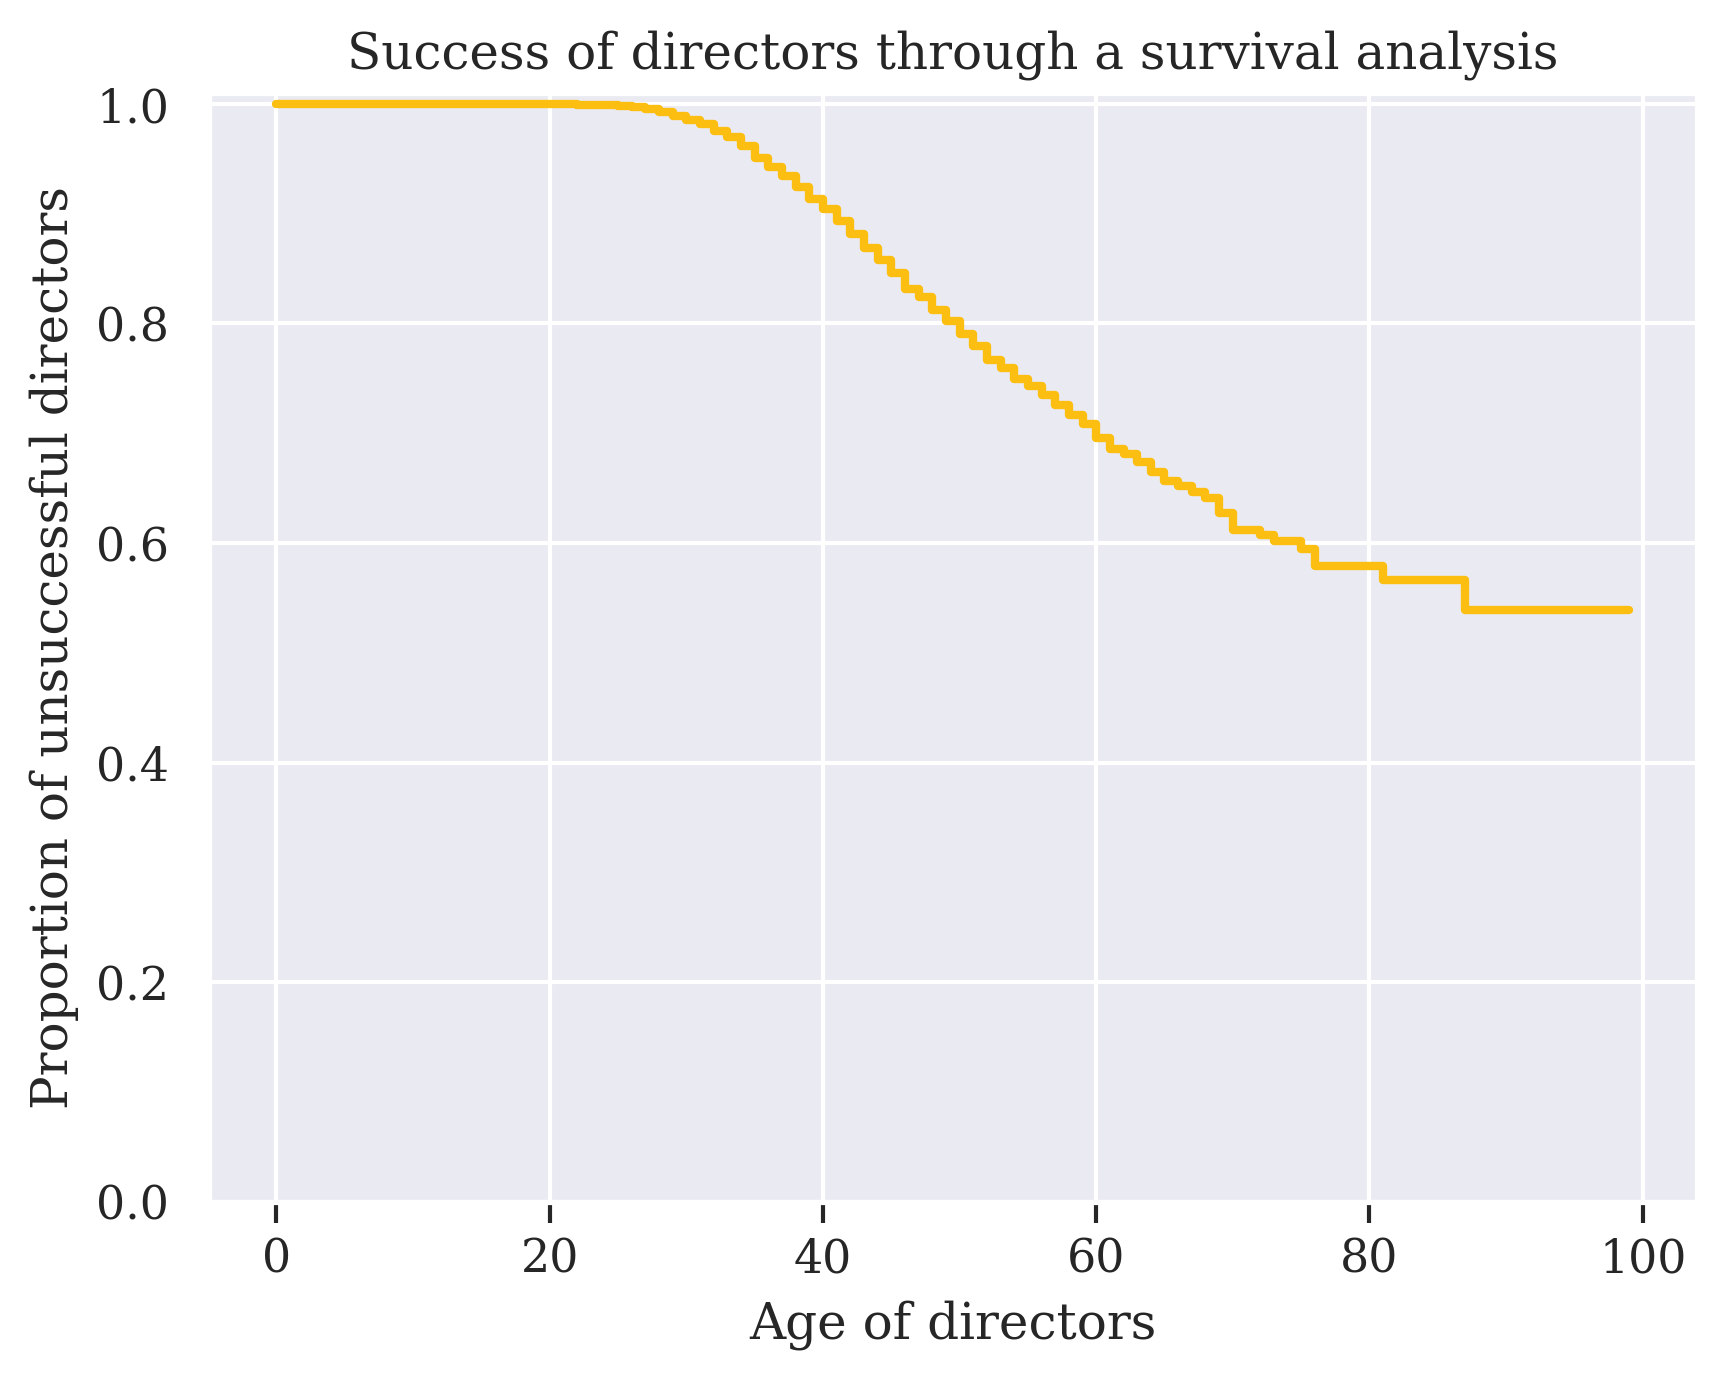

In [72]:
fig = director_sf.plot()
ax = fig.get_axes()[0]
pt = ax.get_lines()[1]
pt.set_visible(False)
ax.get_lines()[0].set_color("#fcbe11")
mean = ax.axvline((movie_director['death_year'] - movie_director['birth_year']).mean(), label='mean age of death', color='#bb4430')
median = ax.axvline((movie_director['death_year'] - movie_director['birth_year']).median(), label='median age of death', color='#185c77')
plt.xlim([18, 100])
plt.title("Success of directors through a survival analysis")
plt.xlabel("Age of directors")
plt.ylabel("Proportion of unsuccessful directors")
plt.legend(handles=[mean, median])
plt.show()
fig.savefig('../docs/static/plots/director_success.png', bbox_inches='tight', dpi=600)

In [ ]:
print(f"The mean age of director deaths is {(movie_director['death_year'] - movie_director['birth_year']).mean(): .2f}, and the median age is {(movie_director['death_year'] - movie_director['birth_year']).median(): .2f}.")